In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg

In [2]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
    sqrtoutputsize = int(np.sqrt(outputsize))
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def NonlinearPoisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    h = 1/(sqrtinputsize-1)
    KX = np.zeros([inputsize,inputsize+1])
    KY = np.zeros([inputsize+1,inputsize])
    for i in range(sqrtinputsize):
        for j in range(sqrtinputsize+1):
            KX[i][j] = a(j*h-0.5*h,i*h)
    for i in range(sqrtinputsize+1):
        for j in range(sqrtinputsize):
            KY[i][j] = a(j*h,i*h-0.5*h)
    OUTPUT = (gallery.nonlinearPoisson((sqrtinputsize,sqrtinputsize),KX,KY)).to_full()
    return OUTPUT

In [3]:
def Multigrid_circle(inputsize, A_A, B, R_A, s, w, NUM_EPOCH):
    A = np.matrix(A_A)
    P = 4*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    for i in range(NUM_EPOCH):
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

In [4]:
def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def rhoAuto(INPUT):
    R = INPUT[0]
    w = INPUT[1]
    P = 4*np.transpose(R)
    M = (w**(-1)) * np.diag(np.diag(A1))
    K = M - A1
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A1),P))),R),A1)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

In [5]:
def optimizer_GD(inputsize, A, R, w, s, learning_rate):
    rhoold = rho(inputsize,A,4*np.transpose(R),R,w,s)
    INPUT = [R,w]
    rhoGra = grad(rhoAuto)
    delta = rhoGra(INPUT)
    R -= learning_rate*delta[0]
    w -= learning_rate*delta[1]
    rhonew = rho(inputsize,A,4*np.transpose(R),R,w,s)
    return R, w, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            P = 4*np.transpose(R)
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhonew <= rhoold and i<100:
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew

In [6]:
finegridsize = 5
s = 1
w = 2/3
MAX_ITER = 50

In [7]:
e = 0.01
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)

In [8]:
inputsize = (2**finegridsize-1)**2
inputsize = int(inputsize)
sqrtinputsize = int(np.sqrt(inputsize))
outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
sqrtoutputsize = int(np.sqrt(outputsize))
h = 1/(sqrtinputsize-1)
A0 = Poisson(inputsize)
A1 = NonlinearPoisson(inputsize)
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
R = Restriction(inputsize)
P = 4*np.transpose(R)

In [9]:
R, w, Rhoold, Rhonew = direct_optimizer_GD(inputsize, A0, A1, Restriction(inputsize),  2/3, s=1, learning_rate = 1e-2)

rho = 0.4849247715461681
rho = 0.48042021493423614
rho = 0.47596712982680617
rho = 0.47157819187969896
rho = 0.4673298740530028
rho = 0.463915002063129
rho = 0.4750616264186332
rho = 0.7041858701753043
rho = 0.6539235139318803
rho = 0.9294153903208883
rho = 0.8448561447046624
rho = 0.5649435777448779
rho = 0.9362428089494544
rho = 0.8857618630626177
rho = 0.6672781029069916
rho = 0.7548790018794691
rho = 0.832932788592409
rho = 0.5133674059728761
rho = 0.9873613167620743
rho = 0.9869466502200245
rho = 0.9865049961527389
rho = 0.9860328445850125
rho = 0.9855260251205
rho = 0.9849795395560721
rho = 0.9843873400263369
rho = 0.9837420305877739
rho = 0.9830344592063565
rho = 0.9822531496300618
rho = 0.9813834939454954
rho = 0.9804065781234621
rho = 0.979297428028353
rho = 0.9780223091043294
rho = 0.976534419610631
rho = 0.9747667296716556
rho = 0.972619466747276
rho = 0.9699368778787757
rho = 0.9664606945176586
rho = 0.9617274636836635
rho = 0.9548108179839886
rho = 0.9435456024459231
rho =

Text(0, 0.5, 'Spectral radius of matrix C')

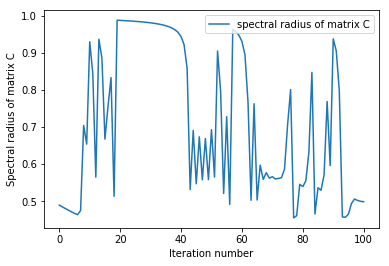

In [11]:
plt.plot(Rhonew,label='spectral radius of matrix C')
plt.legend(loc='upper right')
plt.xlabel('Iteration number')
plt.ylabel('Spectral radius of matrix C')
